In [1]:
import brainpy.math as bm
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D
import jax

# Set up environment and model (from previous guide)
bm.set_dt(0.1)
cann = CANN1D(num=512)

# Create a smooth tracking task
task = SmoothTracking1D(
    cann_instance=cann,                # Link to the CANN model
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),  # External input positions (in radians)
    duration=(10.0, 10.0, 10.0, 10.0), # Duration at each position (ms)
    time_step=bm.get_dt()  # Simulation time step
)

In [2]:
# Generate all task data
task.get_data()

<SmoothTracking1D> Generating Task data: 400it [00:00, 1593.79it/s]


In [3]:
print(f"Data shape: {task.data.shape}")
print(f"Number of time steps: {task.run_steps.shape[0]}")
print(f"Time step size: {task.time_step} ms")
print(f"Total simulation time: {task.run_steps.shape[0] * task.time_step} ms")

Data shape: (400, 512)
Number of time steps: 400
Time step size: 0.1 ms
Total simulation time: 40.0 ms


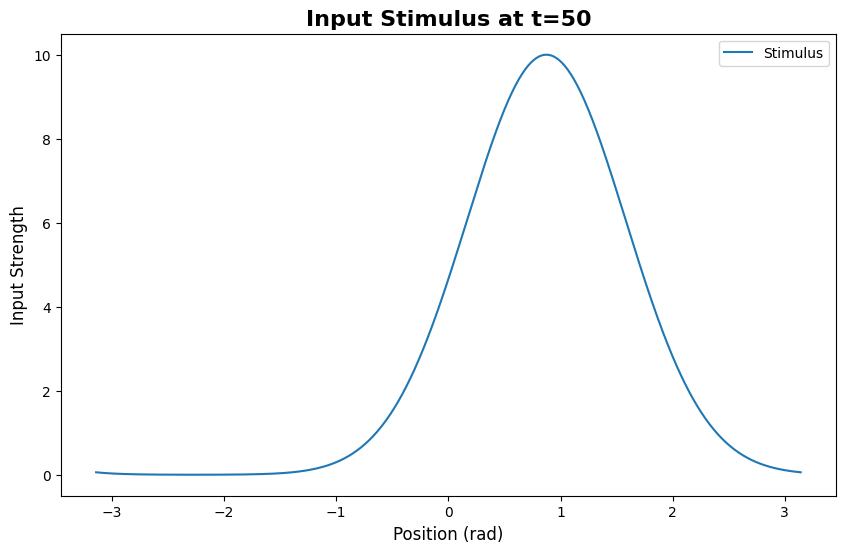

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Input Stimulus at t=50'}, xlabel='Position (rad)', ylabel='Input Strength'>)

In [4]:
from canns.analyzer.visualization import PlotConfigs, energy_landscape_1d_static

# Create configuration for static plot
config = PlotConfigs.energy_landscape_1d_static(
    time_steps_per_second=100,
    title='Input Stimulus at t=50',
    xlabel='Position (rad)',
    ylabel='Input Strength',
    show=True
)

# Plot input at time step 50
energy_landscape_1d_static(
    data_sets={'Stimulus': (cann.x, task.data[50])},
    config=config
)

In [5]:
def run_step(t, stimulus):
    """Simulation step function."""
    cann(stimulus)  # Feed stimulus to model
    return cann.u.value, cann.r.value  # Return synaptic input and activity

# Run the simulation with task data
us, rs = bm.for_loop(
    run_step,
    operands=(task.run_steps, task.data),
    progress_bar=10
)

print(f"Synaptic input shape: {us.shape}")   # (400, 512)
print(f"Neural activity shape: {rs.shape}")  # (400, 512)

  0%|          | 0/400 [00:00<?, ?it/s]

Synaptic input shape: (400, 512)
Neural activity shape: (400, 512)


In [6]:
import brainpy.math as bm  # :cite:p:`wang2023brainpy`
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D

# 1. Setup
bm.set_dt(0.1)

# 2. Create model (auto-initializes)
cann = CANN1D(num=512)

# 3. Create task
task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0, 10.0, 10.0, 10.0),
    time_step=bm.get_dt(),
)
task.get_data()

# 4. Run simulation
def run_step(t, stimulus):
    cann(stimulus)
    return cann.u.value, cann.r.value

us, rs = bm.for_loop(
    run_step,
    operands=(task.run_steps, task.data),
    progress_bar=10
)

print("Simulation complete!")
print(f"Captured {us.shape[0]} time steps of activity")

<SmoothTracking1D> Generating Task data: 400it [00:00, 3246.41it/s]


  0%|          | 0/400 [00:00<?, ?it/s]

Simulation complete!
Captured 400 time steps of activity


In [7]:
task_fast = SmoothTracking1D(
    cann_instance=cann,
    Iext=(0.0, 1.0, 2.0),
    duration=(5.0, 5.0),  # Shorter durations = faster transitions
    time_step=0.1
)

In [9]:
import jax.numpy as jnp

# Track across 10 evenly spaced positions
positions = jnp.linspace(-3.0, 3.0, 10)
durations = [8.0] * 9

task_dense = SmoothTracking1D(
    cann_instance=cann,
    Iext=tuple(positions),
    duration=tuple(durations),
    time_step=0.1
)

In [10]:
# Different durations for each position
task_variable = SmoothTracking1D(
    cann_instance=cann,
    Iext=(0.0, 1.5, -1.0, 2.0),
    duration=(15.0, 5.0, 10.0),  # Stay longer at first position
    time_step=0.1
)

In [11]:
task.get_data()
# Add noise to all inputs
task.data = task.data + 0.1 * jax.random.normal(jax.random.PRNGKey(0), task.data.shape)

<SmoothTracking1D> Generating Task data: 400it [00:00, 9170.08it/s]


In [12]:
import jax.numpy as jnp

# Create custom input sequence
custom_data = jnp.zeros((100, 512))
for t in range(100):
    position = jnp.sin(t * 0.1)  # Sinusoidal movement
    custom_data = custom_data.at[t].set(
        jnp.exp(-0.5 * (cann.x - position)**2 / 0.3**2)
    )

In [ ]:
task.get_data()  # Generates data
# ... use task.data in simulations

# If you change parameters, recreate the task
task_new = SmoothTracking1D(...)
task_new.get_data()